In [ ]:
using Pkg
Pkg.activate("NB02")
Pkg.resolve();

In [ ]:
using Twitter, Graphs, GraphPlot, SparseArrays, LinearAlgebra, Colors, Plots 
using Compose, Fontconfig, Cairo;

---
---
# Laden der Daten

Zunächst laden wir Daten. 

Dazu gibt es in diesen Notebook zwei Optionen.

Für Option 1 wird ein Twitter Account benötigt.

Für Option 2 brauchen wir keinen Twitter Account.


## Option 1: Daten von Twitter laden

Dazu müssen wir uns bei Twitter authentifizieren. 

Im Twitter [Developer Portal](https://developer.twitter.com/en) muss eine neue Application erstellt werden.

Dort können dann `CONSUMER_KEY`, `CONSUMER_SECRET`, `ACCESS_TOKEN` und `ACCESS_TOKEN_SECRET` generiert werden.

Siehe auch die [Dokumentation des Twitter.jl Packages](https://github.com/randyzwitch/Twitter.jl)



In [3]:
CONSUMER_KEY = "";
CONSUMER_SECRET = "";
ACCESS_TOKEN = "";
ACCESS_TOKEN_SECRET = "";

twitterauth(CONSUMER_KEY, CONSUMER_SECRET, ACCESS_TOKEN, ACCESS_TOKEN_SECRET);

Wir laden die letzten 500 Tweet, die den Hashtag `#DataScience` enthalten.

In [4]:
tweets = get_search_tweets(q = "#DataScience", count = 500)
T = tweets["statuses"];

Den letzten dieser Tweets können wir wie folgt anzeigen lassen:

In [ ]:
println(T[1].user["screen_name"])
println(T[1].text)

Wir wollen die Hashtags in den Tweets analysieren. 

Dazu erstellen wir eine Listen von Listen. Die $i$-te Liste enthält die Hashtags im $i$-ten Tweet

In [6]:
hashtags = Vector{Vector{String}}()
for (i,t) in enumerate(T)
    push!(hashtags, Vector{String}())
    for entry in t.entities["hashtags"]
        push!(hashtags[i], entry["text"])
    end
end
filter!(x -> !isempty(x), hashtags)
hashtags[1:5]

5-element Vector{Vector{String}}:
 ["MachineLearning", "AI", "Python"]
 ["MachineLearning", "Algorithms", "ArtificialIntelligence", "DataScience", "Python", "Programming"]
 ["machinelearning", "datascience", "bigdata"]
 ["Python"]
 ["machinelearning", "datascience", "bigdata"]


## Option 2: Daten aus einem .txt File laden


Wir können alte Daten aus einem `.txt` File laden (die Daten wurden am 22.04.2022 generiert).

In [3]:
hashtags = Vector{Vector{String}}()
open("hashtags.txt") do f
    i = 0
    for ln in eachline(f)
        if ln == ""
            push!(hashtags, Vector{String}())
            i+=1
        else
            push!(hashtags[i], ln)
        end
    end
end
hashtags[1:5]

5-element Vector{Vector{String}}:
 ["100Daysofcode", "javascript", "programming", "dev", "linux", "java", "programming", "CodeNewbie"]
 ["100Daysofcode", "javascript", "programming", "dev", "linux", "java", "programming", "CodeNewbie"]
 ["100Daysofcode", "javascript", "programming", "dev", "linux", "java", "programming", "CodeNewbie"]
 ["javascript", "programming", "dev", "linux", "java", "programming", "CodeNewbie", "python"]
 ["javascript", "programming", "dev", "linux", "java", "programming", "CodeNewbie", "python"]

---
# Daten aufbereiten

Wir erstellen das Array `unique_hashtags`, welches alle Hashtags einzeln listet.

In [7]:
all_hashtags = vcat(hashtags...)
unique_hashtags = unique(all_hashtags)

107-element Vector{String}:
 "MachineLearning"
 "AI"
 "Python"
 "Algorithms"
 "ArtificialIntelligence"
 "DataScience"
 "Programming"
 "machinelearning"
 "datascience"
 "bigdata"
 "Bioinformatics"
 "OpenScience"
 "deeplearning"
 ⋮
 "Tech4Good"
 "womenintech"
 "Digital"
 "TechnoCool"
 "rprogramming"
 "ai"
 "ml"
 "artificialintelligence"
 "blockchain"
 "Arduino"
 "Robotics"
 "DIY"

---
---
# Definition des Graphen

Aus den Daten erstellen wir ein Netzwerk.

Die Knoten im Graphen sind die Hashtags.

Wir definieren eine Kante zwischen zwei Knoten, falls die zwei Hashtags in einem gemeinsamen Tweet auftauchen.

Zuerst berechnen wir die Adjazenzmatrix.

In [8]:
n = length(unique_hashtags)
A = zeros(Int, n, n)

function edge(hᵢ, hⱼ)
    for h in hashtags
        if hᵢ in h && hⱼ in h
            return 1
        end
    end
    return 0
end
    
    
for i in 2:(n-1)
    hᵢ = unique_hashtags[i]
    for j in (i+1):n
        hⱼ = unique_hashtags[j]
        A[i,j] = edge(hᵢ, hⱼ)
    end
end    
A = sparse(max.(A, A'))

107×107 SparseMatrixCSC{Int64, Int64} with 764 stored entries:
⢰⡲⡖⠂⠐⠒⠒⠒⠀⠀⠀⠂⠂⠀⠂⠀⠀⠐⠒⠒⠒⠀⠒⠀⠒⠒⠐⠂⠀⠐⡀⢐⠀⠀⠀⠀⠀⠀⠀⠀
⠸⠉⢫⡲⡐⠚⠋⠩⠄⠠⠤⠍⠉⠤⠅⠠⠀⠀⠀⠈⠉⠌⣿⠤⠛⠛⠉⠁⠀⠈⠈⢹⠀⠀⠀⠀⠀⢰⣶⠉
⢰⠀⣰⠈⢠⡶⢀⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⢸⠀⡏⡀⠀⠰⠪⡢⡀⠀⠀⠀⠆⠀⠀⠀⠒⠂⠀⠰⠶⠠⢠⠀⠉⠉⢤⣄⣀⠐⠀⢀⣀⣀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⡁⠀⠀⠀⠈⣮⡻⣀⡂⠀⣀⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠒⠒⠂⠀⠀⠀
⠠⠀⡄⠇⠀⠀⠀⠀⠠⠸⠮⠃⣀⠿⠇⠀⠀⠀⠀⠀⠀⠀⠤⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠤⠤⠄⠀⠀⠀
⠈⠀⠃⡄⠀⠀⠈⠁⠀⢠⣤⡜⠚⡠⡄⠀⠀⠀⠀⠈⠉⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠈⠀⠁⡁⠀⠀⠀⠀⠀⠈⠉⠁⠀⠉⠠⠂⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⢀⠀⠀⠀⠀⠀⠸⠀⠀⠀⠀⠀⠀⠀⠀⠀⠮⠃⣀⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⢸⠀⡀⠀⠀⠀⢀⡀⠀⠀⠀⠀⡀⠀⠀⠀⠀⠸⠾⢃⣀⠀⠀⠀⠀⠀⠀⠀⠀⢀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣀
⠘⠀⡃⠄⠀⠀⠘⡃⠀⠀⠀⠀⠃⠀⠀⠀⠀⠀⠀⠘⠊⠀⠀⠀⠀⠀⡀⠀⠀⠈⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠘⠀⠛⡟⠀⠀⠀⠒⠀⠀⠀⠃⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢪⡲⠀⠀⠐⠂⠀⠀⠀⠘⠀⠀⠀⠀⠀⠘⠛⠀
⢸⠀⣿⠀⠀⠀⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣯⣻⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠰⠀⠇⠀⠀⠀⠀⢷⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠰⠀⠀⠀⠠⡦⣤⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⢀⠀⡀⠀⠀⠀⢀⠘⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢀⡀⠀⠀⠀⠀⠀⠀⠛⠚⠀⠀⠈⠉⠉⠀⠀⠀⠀⠀⠀
⢀⢈⣆⣀⠀⠀⠀⢀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣀⠀⠀⠀⠀⠀⡀⠀⠠⠂⣀⣀⠀⠀⠀⢀⣀⠀
⠀⠀⠀⠀⠀⠀⠀⢸⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡇⠀⠀⢸⣮⡿⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⢸⠀⠀⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣾⡻⡇⠀⠀⠀
⠀⠀⢀⣀⠀⠀⠀⠀⠈⠀⠀⠁⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣀⠀⠀⠀⠀⠀⠀⠀⠀⢀⠀⠀⠉⠉⠁⢀⣀⠀
⠀⠀⡜⠛⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢠⠀⠀⠛⠀⠀⠀⠀⠀⠀⠀⠀⠘⠀⠀⠀⠀⠀⠘⠊⡤

die Adjazenzmatrix `A` definiert den Graphen `G`.

In [9]:
G = Graphs.Graph(A)

{107, 382} undirected simple Int64 graph

Wir entfernen außerdem die Knoten mit Grad 0 aus dem Graphen.

In [10]:
d = Graphs.degree(G)
not0 = findall(d .!= 0)

unique_hashtags = unique_hashtags[not0]
A = A[not0,not0]
d = d[not0]

n = length(unique_hashtags)
G = Graphs.Graph(A)

{98, 382} undirected simple Int64 graph

---
---
# Visualisierung

Wir visualisieren den Graphen wie folgt.

Dabei plotten wir die Labels der 5 Knoten mit den höchsten Graden.

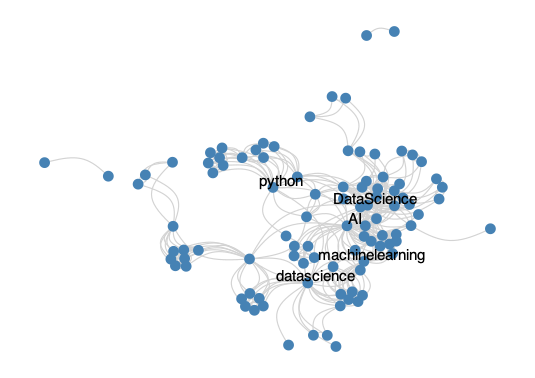

In [11]:
c = sortperm(d, rev = true)[1:5]
labels = ["" for _ in 1:n]
labels[c] = unique_hashtags[c] 
layout= spring_layout(G; C=5)
P1 = gplot(G, layout...;
        linetype="curve", 
        nodelabel=labels,
        nodelabeldist=2,
        nodefillc = colorant"steelblue"
)

---
---
# Die Laplace Matrix

Wir berechnen die Laplace Matrix `L` von `G`.

In [12]:
L = zeros(n, n)
for i in 1:n
    for j in 1:n
        if i == j
            L[i,j] = 1
        elseif A[i,j] == 1
            L[i,j] = - 1 / sqrt(d[i] * d[j])
        end
    end
end
L;

Die Eigenwerte von `L` werden dann wie folgt berechnet:

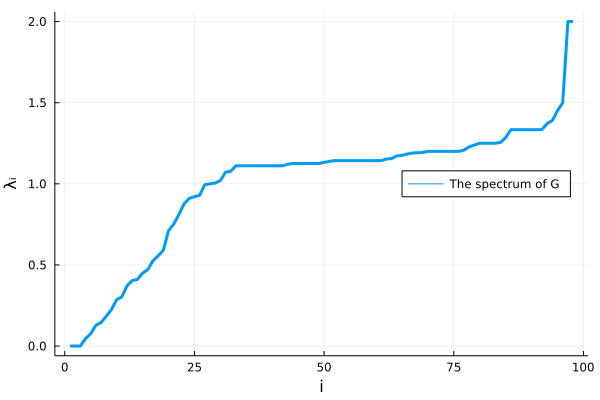

┌ Info: Precompiling GR_jll [d2c73de3-f751-5644-a686-071e5b155ba9]
└ @ Base loading.jl:1423


In [13]:
E = eigen(L)
λ = E.values
P2 = plot(λ, label = "The spectrum of G", 
             legend = 0,
             linewidth = 3,
             xlab = "i",
             ylab = "λᵢ")

Die Anzahl der Komponenten ist gleich der Dimension des Kerns von `L`.

In [14]:
n_components = count(λ .< 1e-14)

3

In [15]:
C = connected_components(G)

3-element Vector{Vector{Int64}}:
 [1, 2, 3, 4, 5, 6, 7, 8, 9, 12  …  89, 90, 91, 92, 93, 94, 95, 96, 97, 98]
 [10, 11]
 [38, 39]

In [16]:
sum(λ), n

(97.99999999999997, 98)

---
# Analyse einer Komponente

Wir analyieren nun die größte Zusammenhangskomponente `H` von `G`

Wir berechnen auch die Zusammenhangskomponenten

In [17]:
k = findmax(length.(C))
I = C[k[2]];
H = Graph(A[I, I])

{94, 380} undirected simple Int64 graph

Wir plotten zunächst diese Komponente.

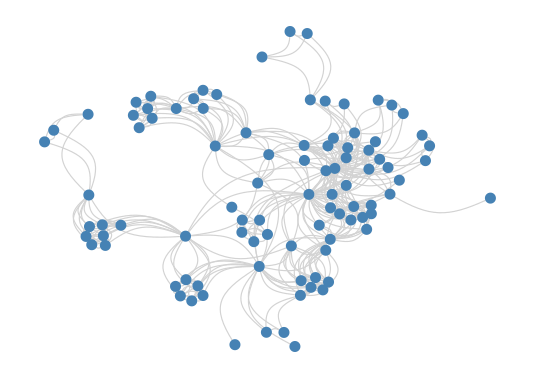

In [18]:
layout_H = (layout[1][I], layout[2][I])
P3 = gplot(H, layout_H...;
        linetype="curve", 
        nodelabeldist=2,
        nodefillc = colorant"steelblue"
)

Jetzt berechnen wir das Spektrum von `H`.

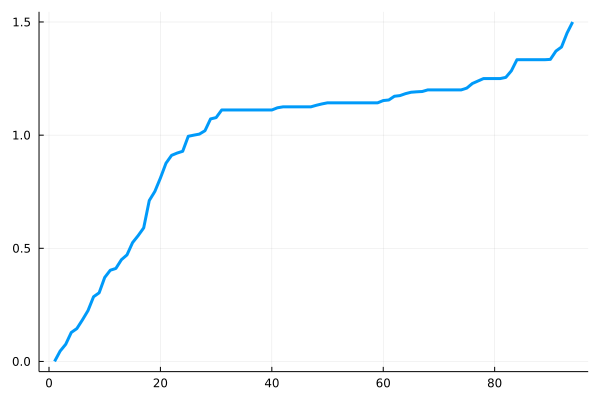

In [19]:
L_H = L[I,I]
E_H = eigen(L_H)
λ_H = E_H.values
P4 = plot(λ_H, legend = false, linewidth = 3)

Sei nun `w` Eigenvektor von $\lambda_G$. 

Wir plotten die Knoten je nach Vorzeichen von `w` rot oder blau. Wir färben gelb, falls der Eintrag von `w` Null ist.

Dies zeigt uns Komponenten von `H`, die "fast" zusammenhängend sind.

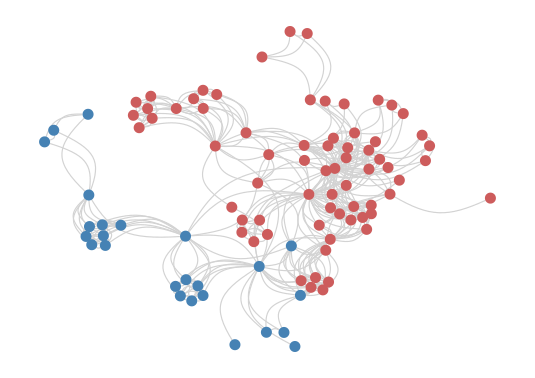

In [20]:
w = E_H.vectors[:,2]
cols = []
for wᵢ in w
    if abs(wᵢ) > 1e-12 
        if wᵢ < 0
            push!(cols, colorant"steelblue")
        else
            push!(cols, colorant"indianred")
        end
    else
        push!(cols, colorant"orange")
    end
end
layout= x -> spring_layout(x; C=5)
P5 = gplot(H, layout_H...;
        linetype="curve", 
        nodelabeldist=2,
        nodefillc = cols
)

Die Labels der zwei Cluster sind wie folgt:

In [24]:
unique_hashtags[I][w .> 0]

69-element Vector{String}:
 "AI"
 "Python"
 "Algorithms"
 "ArtificialIntelligence"
 "DataScience"
 "Programming"
 "machinelearning"
 "bigdata"
 "deeplearning"
 "proteins"
 "IA"
 "ML"
 "5G"
 ⋮
 "Infographic"
 "cprogramming"
 "cprogram"
 "cloud"
 "cloudcomputing"
 "ai"
 "ml"
 "artificialintelligence"
 "blockchain"
 "Arduino"
 "Robotics"
 "DIY"

In [25]:
unique_hashtags[I][w .< 0]

25-element Vector{String}:
 "datascience"
 "Scientists"
 "Risk"
 "Disorder"
 "Kids"
 "OTTalk"
 "OccupationalTherapy"
 "healthcare"
 "innovation"
 "science"
 "philosophy"
 "bayes"
 "Bangalore"
 "digitaltransformation"
 "tech"
 "analytics"
 "ds"
 "statistics"
 "Assessment"
 "economy"
 "marketing"
 "investing"
 "Tech4Good"
 "womenintech"
 "Digital"

Jetzt färben wir ähnlich für den größten Eigenwert.

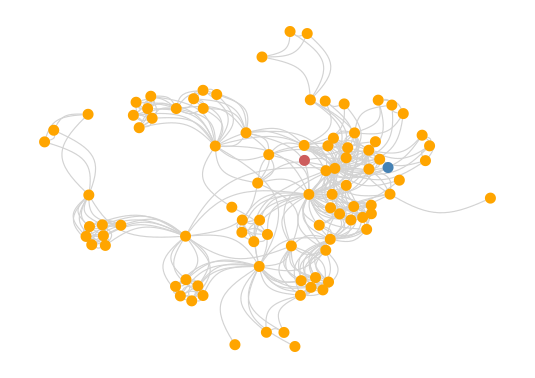

In [21]:
u = E_H.vectors[:,end]
cols = []
for uᵢ in u
    if abs(uᵢ) > 1e-12 
        if uᵢ < 0
            push!(cols, colorant"steelblue")
        else
            push!(cols, colorant"indianred")
        end
    else
        push!(cols, colorant"orange")
    end
end
P6 = gplot(H, layout_H...;
        linetype="curve", 
        nodelabeldist=2,
        nodefillc = cols
)

In [27]:
unique_hashtags[I][u .> 1e-12], unique_hashtags[I][u .< -1e-12]

(["NumPy"], ["CheatSheet"])

Die Plots können schließlich wie folgt gespeichert werden:

In [ ]:
draw(PDF("plot.pdf", 16cm, 16cm), P1)